In [ ]:
!pip install portalocker>=2.0.0
!pip install gensim #4.2.0

In [ ]:
!pip install torchtext==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display, SVG


from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset


import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_embeddings(word_embeddings, vocab):
    tsne = TSNE(n_components=2, random_state=42)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    plt.figure(figsize=(12, 12))
    for i, word in enumerate(vocab.get_itos()):
        x, y = word_embeddings_2d[i]
        plt.scatter(x, y, color="blue", alpha=0.6)
        plt.annotate(word, (x, y), fontsize=9)

    plt.title("Word Embeddings Visualization (t-SNE)")
    plt.show()


In [ ]:
def find_similar_words(word, embedding_word, top_k=5):
    if word not in embedding_word:
        print(f"{word} not found in the vocabulary.")
        return

    # Get the embedding for the given word
    target_embedding = embedding_word[word]
    # Calculate cosine similarities between the target word and all other words

    similarities = {} # Initialize similarities as a dictionary
    for w, embedding in embedding_word.items():
        if w != word:
            # Store the similarity score with the word as the key
            similarities[w] = torch.dot(target_embedding, embedding) / (torch.norm(target_embedding) * torch.norm(embedding))

    # Sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Return the top k similar words
    similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return similar_words

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    epoch_losses = []

    use_embedding_bag = any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules())

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        running_loss = 0.0

        for samples in dataloader:
            optimizer.zero_grad()

            if use_embedding_bag:
                target, context, offsets = samples
                predicted = model(context, offsets)
            else:
                target, context = samples
                predicted = model(context)

            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            running_loss += loss.item()

        epoch_losses.append(running_loss / len(dataloader))

    return model, epoch_losses


# Create and train word2vec models

In [ ]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


In [ ]:
# Step 1: Get tokenizer
tokenizer = get_tokenizer('basic_english')

# Step 2: Tokenize sentences
def tokenizer_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

tokenizer_toy_data = tokenizer(toy_data)

vocab = build_vocab_from_iterator(tokenizer_data(tokenizer_toy_data), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])



# Test


In [ ]:
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample:", encoded_sample)
print(tokenized_sample)

Encoded sample: [20, 108, 20, 7, 2, 133]
['i', 'wish', 'i', 'was', 'a', 'baller']


In [ ]:
text_pipeline = lambda tokens:[vocab[token] for token in tokens]

# Continuous Bag of Words (CBOW)

In [ ]:
CONTEXT_SIZE = 2

cobow_data = []

for i in range(CONTEXT_SIZE, len(tokenizer_toy_data) - CONTEXT_SIZE):
    context = tokenizer_toy_data[i - CONTEXT_SIZE:i] + tokenizer_toy_data[i + 1:i + CONTEXT_SIZE + 1]
    target = tokenizer_toy_data[i]
    cobow_data.append((context, target))

In [ ]:
print(cobow_data[1])

(['wish', 'i', 'little', 'bit'], 'was')


In [ ]:
print(cobow_data[2])

(['i', 'was', 'bit', 'taller'], 'little')


In [ ]:
def collate_batch(batch):
    target_list = []
    context_list = []
    offsets = [0]

    for context, target in batch:
        target_list.append(vocab[target])

        context_tensor = torch.tensor(text_pipeline(context), dtype=torch.int64)
        context_list.append(context_tensor)

        offsets.append(context_tensor.size(0))

    # Convert lists into tensors
    target_tensor = torch.tensor(target_list, dtype=torch.int64) # Convert target_list to a tensor
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_tensor = torch.cat(context_list)  # Concatenate context tensors if necessary


    return target_tensor.to(device), context_tensor.to(device), offsets.to(device) # Move tensors to device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
target_list, context_list, offsets=collate_batch(cobow_data[0:10])
print(f"target_list(Tokenized target words): {target_list} , context_list(Surrounding context words): {context_list} , offsets(Starting indexes of context words for each target): {offsets} ")


target_list(Tokenized target words): tensor([ 20,   7, 272, 136, 376,  20, 108,  20,   7,   2], device='cuda:0') , context_list(Surrounding context words): tensor([ 20, 108,   7, 272, 108,  20, 272, 136,  20,   7, 136, 376,   7, 272,
        376,  20, 272, 136,  20, 108, 136, 376, 108,  20, 376,  20,  20,   7,
         20, 108,   7,   2, 108,  20,   2, 133,  20,   7, 133,  14],
       device='cuda:0') , offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36], device='cuda:0') 


In [ ]:
BATCH_SIZE = 64  # batch size for training

dataloader_cbow = DataLoader(
    cobow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
print(dataloader_cbow)

In [ ]:
class CBOW(nn.Module):
    # Initialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):

        super(CBOW, self).__init__()
         # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # Define the first linear layer with input size embed_dim and output size embed_dim//2
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        # Define the fully connected layer with input size embed_dim//2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2, vocab_size)


        self.init_weights()
    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialize the biases of the fully connected layer to zeros
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        # Pass the input text and offsets through the embedding layer
        out = self.embedding(text, offsets)
        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))
        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)


In [ ]:
vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

In [ ]:
LR = 5  # learning rate

# Define the CrossEntropyLoss criterion. It is commonly used for multi-class classification tasks.
# This criterion combines the softmax function and the negative log-likelihood loss.
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer using stochastic gradient descent (SGD).
# It optimizes the parameters of the model_cbow, which are obtained by model_cbow.parameters().
# The learning rate (lr) determines the step size for parameter updates during optimization.
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)

# Define a learning rate scheduler.
# The StepLR scheduler adjusts the learning rate during training.
# It multiplies the learning rate by gamma every step_size epochs (here, 1.0).
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


In [ ]:
model_cbow, epoch_losses=train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=40)

Training Progress: 100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Text(0.5, 0, 'epochs')

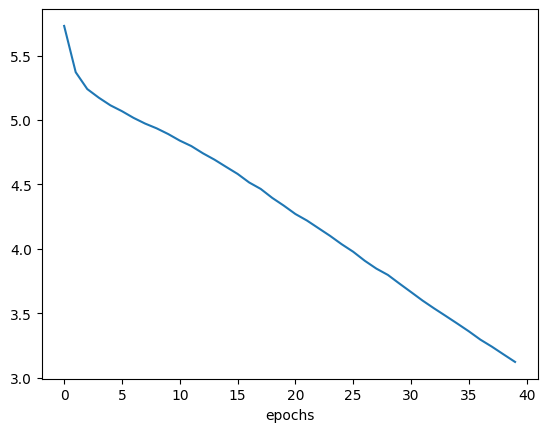

In [ ]:
plt.plot(epoch_losses)
plt.xlabel("epochs")

In [ ]:
device

device(type='cuda')

In [ ]:
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()  # Safe conversion

In [ ]:
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word in the vocab
print(word_embeddings[word_index])

[ 0.32578123  0.47645923  0.19932473 -0.09656703  0.21011665  0.15067421
  0.2446639  -0.45915687  0.4519278   0.07521451  0.08330065 -0.39126542
 -0.5405388  -0.438016    0.45193526 -0.35958236  0.44903553 -0.52885175
  0.43601903 -0.18727478 -0.12478054  0.39831313 -0.18956101 -0.12169143]


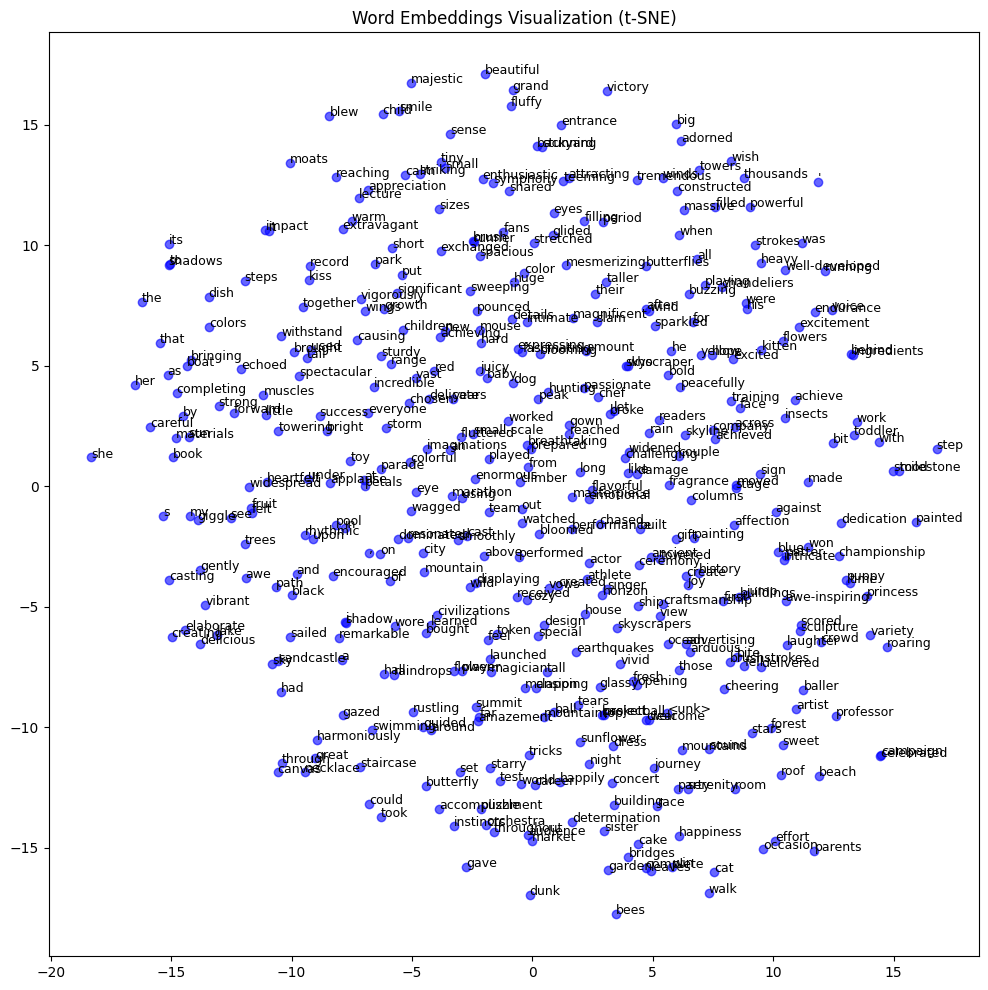

In [ ]:
plot_embeddings(word_embeddings,vocab=vocab)

# Skip-gram model

In [ ]:
CONTEXT_SIZE = 2
skip_data = []

# Iterate over words, leaving space for context window
for i in range(CONTEXT_SIZE, len(tokenizer_toy_data) - CONTEXT_SIZE):
    target = tokenizer_toy_data[i]  # Target word
    context_words = tokenizer_toy_data[i - CONTEXT_SIZE : i] + tokenizer_toy_data[i + 1 : i + CONTEXT_SIZE + 1]

    # Create (target, context) pairs
    skip_data.extend((target, word) for word in context_words)


In [ ]:
skip_data_=[[(sample[0],word) for word in  sample[1]] for sample in skip_data]

In [ ]:
skip_data_flat= [item  for items in  skip_data_ for item in items]
skip_data_flat[8:28]

[('i', 'l'),
 ('i', 'i'),
 ('i', 't'),
 ('i', 't'),
 ('i', 'l'),
 ('i', 'e'),
 ('was', 'w'),
 ('was', 'i'),
 ('was', 's'),
 ('was', 'h'),
 ('was', 'i'),
 ('was', 'l'),
 ('was', 'i'),
 ('was', 't'),
 ('was', 't'),
 ('was', 'l'),
 ('was', 'e'),
 ('was', 'b'),
 ('was', 'i'),
 ('was', 't')]

In [ ]:
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:

        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

In [ ]:
dataloader = DataLoader(skip_data_flat, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
next(iter(dataloader))

(tensor([20,  0, 20, 17,  0,  0,  2, 17,  0, 20,  0,  0,  0,  0,  0, 20, 17,  0,
         20,  0, 20,  0,  0,  0,  0,  0, 20,  0, 20,  0,  2, 17,  0, 20,  0,  0,
          2,  0,  0,  0,  0,  0,  2, 17,  0, 20,  0,  0,  0,  0,  0,  2,  0,  0,
          0,  0, 20,  0, 20,  0,  0,  0,  0,  0], device='cuda:0'),
 tensor([ 20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,  20,
           7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 272, 136,
         136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136,
         136, 376, 376, 376, 376, 376, 376, 376], device='cuda:0'))

In [ ]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        # Define the embeddings layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )

        # Define the fully connected layer
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        # Perform the forward pass
        # Pass the input text through the embeddings layer
        out = self.embeddings(text)

        # Pass the output of the embeddings layer through the fully connected layer
        # Apply the ReLU activation function
        out = torch.relu(out)
        out = self.fc(out)

        return out

In [ ]:
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

In [ ]:
LR = 5  # learning rate
#BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
model_sg, epoch_losses=train_model(model_sg, dataloader, criterion, optimizer, num_epochs=40)

Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


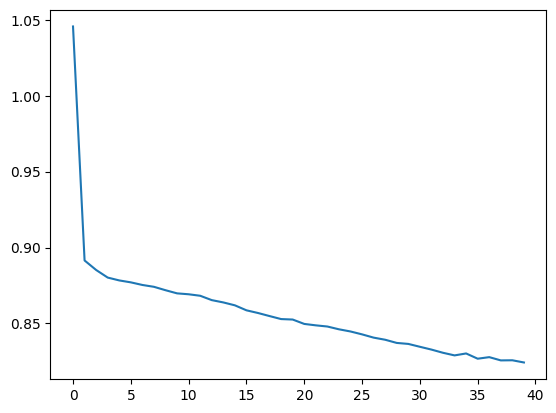

In [ ]:
plt.plot(epoch_losses)

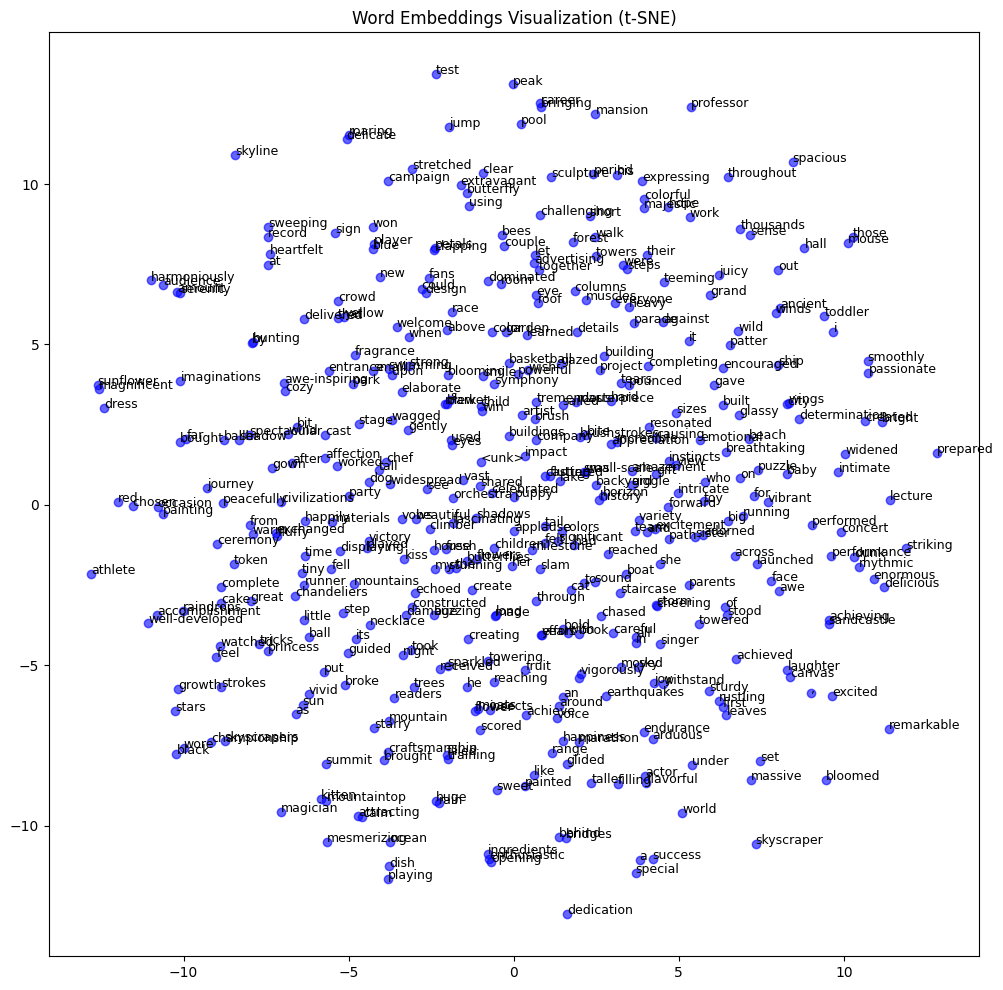

In [ ]:
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings,vocab=vocab)

# Applying pretrained word embeddings (optional)
## Load Stanford GloVe model

In [ ]:
# creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name ='6B') # you can specify the model with the following format: GloVe(name='840B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:50<00:00, 7856.51it/s]


In [ ]:
# load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)

In [ ]:
word_to_index = glove_vectors_6B.stoi  # Vocabulary index mapping
word_to_index['team']

145

In [ ]:
embeddings_Glove6B.weight[word_to_index['team']]

tensor([-2.7011e-02,  1.1299e+00,  4.4708e-02, -4.0380e-01, -4.7284e-02,
         9.2736e-02, -2.0715e-01,  2.6137e-01,  2.4730e-01, -8.8769e-01,
         3.1309e-01, -1.4940e-01,  4.9929e-03, -1.1520e-01, -1.7990e-01,
         6.4681e-01,  1.5044e-01, -3.4580e-01,  2.3370e-03, -7.5788e-01,
         1.6048e-01, -2.9066e-02,  1.7194e-01, -4.2799e-02,  3.4297e-02,
        -1.1400e-01, -2.1149e-01,  3.6118e-01, -3.3393e-01, -1.3581e-01,
         1.7858e-01, -2.3381e-01, -8.3367e-02,  1.0626e-01, -1.7301e+00,
         5.2052e-01,  3.7855e-01,  5.5852e-01, -1.0172e-01, -1.8644e-01,
        -1.2096e-01, -5.2009e-02,  1.9565e-01, -1.2685e-01, -3.7493e-01,
         9.7457e-02,  1.7014e-01,  7.7521e-02, -2.1946e-01,  1.4490e-01,
         1.2733e-01, -2.2223e-01, -3.1548e-01,  1.1137e-01, -4.0263e-01,
         8.3553e-01, -7.5475e-03,  3.6725e-01,  1.2324e-02, -1.0033e-01,
        -6.0014e-01,  4.2763e-01, -2.4048e-01, -2.8162e-01,  4.6409e-02,
        -3.7942e-01, -8.0836e-02, -3.2884e-01, -9.3

In [ ]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


In [ ]:
embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector

In [ ]:
# Call the function to find similar words
target_word = "small"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

2 most similar words to small: ['tiny', 'big']


# Train a word2vec model from gensim

In [ ]:
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]
sentences = [[word.lower() for word in sentence] for sentence in sentences]


In [ ]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

In [ ]:
w2v_model.build_vocab(sentences, progress_per=100000)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(55, 420)

In [ ]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

Similar words to 'pizza': [('to', 0.170244961977005), ('is', 0.1390952169895172), ('my', 0.03540320321917534), ('like', 0.004472944885492325), ('pasta', -0.005862740334123373), ('i', -0.02750754915177822), ('favorite', -0.027992047369480133), ('eat', -0.044601183384656906), ('food', -0.06864096224308014), ('enjoy', -0.17301428318023682)]
Similarity between 'pizza' and 'pasta': -0.005862741


In [ ]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

Word: pizza, Embedding: [[-0.00714022  0.00123998 -0.00717622 -0.0022417   0.00371598  0.00583061
   0.00120213  0.00210559 -0.00411537  0.00722163 -0.00630376  0.0046457
  -0.00822015  0.00203703 -0.00497838 -0.0042473  -0.00310639  0.00565345
   0.00579695 -0.00498193  0.00077337 -0.00849349  0.00781617  0.0092573
  -0.00274196  0.00080025  0.0007445   0.0054774  -0.00860765  0.00058363
   0.00687292  0.00223263  0.00112718 -0.00932121  0.00847941 -0.00626033
  -0.00299176  0.00349312 -0.00077406  0.00140831  0.00178567 -0.00682942
  -0.00972678  0.00903786  0.0061995  -0.0069122   0.00339904  0.00020766
   0.00475404 -0.00711863  0.00402571  0.00434621  0.00995607 -0.00447163
  -0.00139091 -0.00732117 -0.0096983  -0.00908488 -0.00102354 -0.00650586
   0.00484972 -0.00616477  0.00252523  0.0007378  -0.00339542 -0.00097725
   0.00997474  0.00914589 -0.00446644  0.00907925 -0.00564109  0.00593694
  -0.0030968   0.0034326   0.0030185   0.00689902 -0.00237263  0.00877459
   0.00758869 -0

# Text classification using pretrained word embeddings

In [ ]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(["<unk>","Hello","hello"])

[0, 0, 13077]

In [ ]:
# Define tokenizer

tokenizer = get_tokenizer("basic_english")
# Define functions to process text and labels

In [ ]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [ ]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

In [ ]:
def text_pipeline(x):
    x=x.lower()# you need this as your vocab is in lower case
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# you need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


In [ ]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [ ]:
label, text, offsets=next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

tensor([1, 1, 2, 2, 0, 3, 1, 3, 0, 0, 3, 1, 0, 2, 3, 2, 0, 2, 0, 3, 2, 2, 3, 2,
        1, 1, 3, 0, 0, 2, 1, 3, 0, 3, 1, 3, 3, 0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2,
        2, 2, 2, 2, 0, 2, 3, 2, 0, 1, 2, 0, 3, 3, 2, 2], device='cuda:0') tensor([3591,   16,    9,  ..., 3721, 1646,    4], device='cuda:0') tensor([   0,   48,   82,  116,  163,  210,  251,  285,  319,  366,  396,  437,
         469,  512,  545,  592,  641,  686,  723,  757,  802,  841,  895,  937,
        1028, 1065, 1099, 1140, 1185, 1228, 1270, 1354, 1415, 1459, 1496, 1540,
        1578, 1625, 1667, 1686, 1736, 1792, 1837, 1883, 1941, 1984, 2024, 2066,
        2091, 2152, 2201, 2235, 2265, 2303, 2339, 2385, 2437, 2463, 2496, 2542,
        2578, 2616, 2663, 2693, 2732], device='cuda:0')


(torch.Size([64]), torch.Size([2732]), torch.Size([65]))

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        # you get the average of word embeddings in the text
        means = []
        for i in range(1,len(offsets)):
            #this is like eme
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

In [ ]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [ ]:
# Define hyperparameters
vocab_size=len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [ ]:
evaluate(test_dataloader)

0.2561842105263158

In [ ]:
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):

    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()


            predicted_label = model(text, offsets)

            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')

    return model,cum_loss_list,acc_epoch


In [ ]:
# Define hyperparameters
LR=0.1
EPOCHS = 10


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model,cum_loss_list,acc_epoch  = train_TextClassification(model,train_dataloader,criterion,optimizer,EPOCHS)

100%|██████████| 10/10 [02:54<00:00, 17.50s/it]


In [ ]:
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

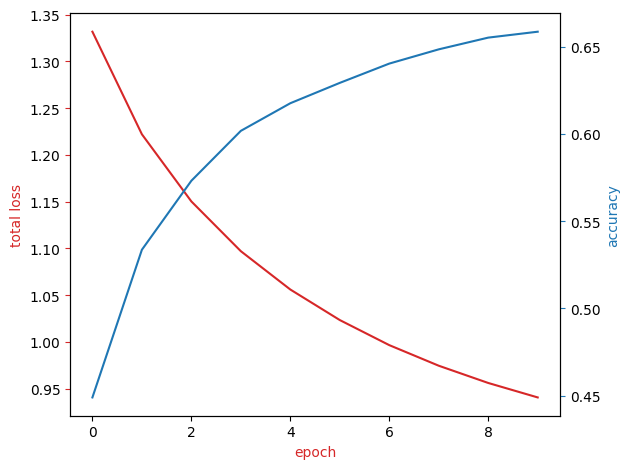

In [ ]:
plot(cum_loss_list,acc_epoch)

In [ ]:
evaluate(test_dataloader)

0.6603947368421053